In [1]:
import os
from functools import partial
from itertools import product

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from pygod.utils import load_data
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

from NEExT.collections import EgonetCollection
from NEExT.experiment_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.io import GraphIO
from NEExT.outliers import CosineOutlierDetector, OutlierDataset, LGBMOutlier

%reload_ext autoreload
%autoreload 2

In [2]:
graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [3]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=5, feature_list=graph_data["feature_list"])

In [4]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embedding",
    structural_embedding_dimension=5,
    feature_embedding_dimension=5,
    embedding_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

In [5]:
def objective(trial: optuna.Trial, model: str):
    if model == "cosine":
        top_k = trial.suggest_int("top_k", 1, 20)
        detector = CosineOutlierDetector(top_k=top_k)
    elif model == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model == "lgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 1, 75),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 1, 100),
            "max_depth": trial.suggest_int("max_depth", 1, 100),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_alpha": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_lambda": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1),
        }

        detector = LGBMOutlier(**params)

    metric = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(5),
        n_jobs=-1,
        scoring=make_scorer(roc_auc_score),
    )
    return metric.mean()

In [6]:
model = "lgbm"
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, model=model), n_trials=50, n_jobs=4)

[I 2025-03-30 19:42:44,279] A new study created in memory with name: no-name-1fd45420-2504-4ee1-8f45-5fe151410c62


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:50,403] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 49, 'min_data_in_leaf': 6, 'num_leaves': 26, 'max_depth': 59, 'class_weight': 'balanced', 'learning_rate': 1.2686945047566499e-05, 'colsample_bytree': 0.7958450479757826}. Best is trial 3 with value: 0.5.
[I 2025-03-30 19:42:50,455] Trial 4 finished with value: 0.7375 and parameters: {'n_estimators': 8, 'min_data_in_leaf': 3, 'num_leaves': 8, 'max_depth': 71, 'class_weight': None, 'learning_rate': 1.0430385495205712, 'colsample_bytree': 0.21338334736385134}. Best is trial 4 with value: 0.7375.
[I 2025-03-30 19:42:50,511] Trial 5 finished with value: 0.5 and parameters: {'n_estimators': 36, 'min_data_in_leaf': 10, 'num_leaves': 20, 'max_depth': 90, 'class_weight': None, 'learning_rate': 1.5976451261449324e-05, 'colsample_bytree': 0.500620676670853}. Best is trial 4 with value: 0.7375.
[I 2025-03-30 19:42:50,553] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 17, 'min_data_in_

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:50,585] Trial 7 finished with value: 0.5 and parameters: {'n_estimators': 71, 'min_data_in_leaf': 10, 'num_leaves': 81, 'max_depth': 98, 'class_weight': 'balanced', 'learning_rate': 0.0019126660420035286, 'colsample_bytree': 0.9692199139426187}. Best is trial 4 with value: 0.7375.
[I 2025-03-30 19:42:50,629] Trial 8 finished with value: 0.5 and parameters: {'n_estimators': 22, 'min_data_in_leaf': 7, 'num_leaves': 55, 'max_depth': 22, 'class_weight': None, 'learning_rate': 0.00015307989230067226, 'colsample_bytree': 0.6848784957384515}. Best is trial 4 with value: 0.7375.
[I 2025-03-30 19:42:50,668] Trial 0 finished with value: 0.778125 and parameters: {'n_estimators': 18, 'min_data_in_leaf': 5, 'num_leaves': 24, 'max_depth': 99, 'class_weight': 'balanced', 'learning_rate': 0.7877995856670541, 'colsample_bytree': 0.5527791567862474}. Best is trial 0 with value: 0.778125.
[I 2025-03-30 19:42:50,677] Trial 9 finished with value: 0.5 and parameters: {'n_estimators': 66,

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294

[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Info] Number of pos

[I 2025-03-30 19:42:50,823] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 8, 'num_leaves': 33, 'max_depth': 33, 'class_weight': 'balanced', 'learning_rate': 3.4334157150305546e-05, 'colsample_bytree': 0.8271782877924791}. Best is trial 0 with value: 0.778125.
[I 2025-03-30 19:42:50,918] Trial 13 finished with value: 0.75625 and parameters: {'n_estimators': 2, 'min_data_in_leaf': 1, 'num_leaves': 35, 'max_depth': 24, 'class_weight': 'balanced', 'learning_rate': 1.2654343895722187, 'colsample_bytree': 0.44873223045968713}. Best is trial 0 with value: 0.778125.
[I 2025-03-30 19:42:50,936] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 63, 'min_data_in_leaf': 6, 'num_leaves': 35, 'max_depth': 88, 'class_weight': None, 'learning_rate': 0.00012386634996575653, 'colsample_bytree': 0.24710570800185705}. Best is trial 0 with value: 0.778125.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: class_weight
Training until validation scores don't improve for 5 rounds
[LightGBM]

[I 2025-03-30 19:42:51,092] Trial 14 finished with value: 0.5 and parameters: {'n_estimators': 2, 'min_data_in_leaf': 1, 'num_leaves': 2, 'max_depth': 71, 'class_weight': 'balanced', 'learning_rate': 1.4662414005598048, 'colsample_bytree': 0.20924168541031804}. Best is trial 0 with value: 0.778125.
[I 2025-03-30 19:42:51,101] Trial 15 finished with value: 0.775 and parameters: {'n_estimators': 6, 'min_data_in_leaf': 1, 'num_leaves': 5, 'max_depth': 72, 'class_weight': 'balanced', 'learning_rate': 1.3841921136974784, 'colsample_bytree': 0.22900351681215478}. Best is trial 0 with value: 0.778125.
[I 2025-03-30 19:42:51,189] Trial 16 finished with value: 0.8 and parameters: {'n_estimators': 29, 'min_data_in_leaf': 1, 'num_leaves': 3, 'max_depth': 1, 'class_weight': 'balanced', 'learning_rate': 1.8888723848703164, 'colsample_bytree': 0.4552496742502501}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,206] Trial 17 finished with value: 0.775 and parameters: {'n_estimators': 29, 'm

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 173
Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 0.978516
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-30 19:42:51,369] Trial 18 finished with value: 0.565625 and parameters: {'n_estimators': 31, 'min_data_in_leaf': 1, 'num_leaves': 16, 'max_depth': 1, 'class_weight': 'balanced', 'learning_rate': 0.14971422644793841, 'colsample_bytree': 0.44708783841703525}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,398] Trial 19 finished with value: 0.525 and parameters: {'n_estimators': 30, 'min_data_in_leaf': 3, 'num_leaves': 15, 'max_depth': 76, 'class_weight': 'balanced', 'learning_rate': 0.18529426397191023, 'colsample_bytree': 0.39179394555857133}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,442] Trial 20 finished with value: 0.546875 and parameters: {'n_estimators': 30, 'min_data_in_leaf': 3, 'num_leaves': 16, 'max_depth': 4, 'class_weight': 'balanced', 'learning_rate': 0.12979755186753822, 'colsample_bytree': 0.47290669581215794}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,503] Trial 21 finished with value: 0.56875 and parameters: {'n_estimat

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2025-03-30 19:42:51,657] Trial 22 finished with value: 0.578125 and parameters: {'n_estimators': 39, 'min_data_in_leaf': 4, 'num_leaves': 72, 'max_depth': 35, 'class_weight': 'balanced', 'learning_rate': 0.10165621765186307, 'colsample_bytree': 0.5849412513031198}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,672] Trial 23 finished with value: 0.5 and parameters: {'n_estimators': 22, 'min_data_in_leaf': 4, 'num_leaves': 67, 'max_depth': 39, 'class_weight': 'balanced', 'learning_rate': 0.07975297010015495, 'colsample_bytree': 0.6221964538194297}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,697] Trial 24 finished with value: 0.621875 and parameters: {'n_estimators': 12, 'min_data_in_leaf': 4, 'num_leaves': 2, 'max_depth': 43, 'class_weight': 'balanced', 'learning_rate': 7.793784101759109, 'colsample_bytree': 0.6011565100799273}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:51,747] Trial 25 finished with value: 0.68125 and parameters: {'n_estimators': 

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:52,016] Trial 27 finished with value: 0.628125 and parameters: {'n_estimators': 10, 'min_data_in_leaf': 2, 'num_leaves': 3, 'max_depth': 80, 'class_weight': 'balanced', 'learning_rate': 9.52440868574123, 'colsample_bytree': 0.3282947489532053}. Best is trial 16 with value: 0.8.
[I 2025-03-30 19:42:52,024] Trial 26 finished with value: 0.8125 and parameters: {'n_estimators': 12, 'min_data_in_leaf': 2, 'num_leaves': 4, 'max_depth': 80, 'class_weight': 'balanced', 'learning_rate': 7.589190963758858, 'colsample_bytree': 0.3546537942208878}. Best is trial 26 with value: 0.8125.
[I 2025-03-30 19:42:52,056] Trial 28 finished with value: 0.790625 and parameters: {'n_estimators': 10, 'min_data_in_leaf': 2, 'num_leaves': 25, 'max_depth': 80, 'class_weight': 'balanced', 'learning_rate': 8.462023341233136, 'colsample_bytree': 0.32388998338620406}. Best is trial 26 with value: 0.8125.
[I 2025-03-30 19:42:52,064] Trial 29 finished with value: 0.5 and parameters: {'n_estimators': 

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:52,402] Trial 30 finished with value: 0.5 and parameters: {'n_estimators': 21, 'min_data_in_leaf': 5, 'num_leaves': 28, 'max_depth': 11, 'class_weight': 'balanced', 'learning_rate': 0.02279810672027259, 'colsample_bytree': 0.5314361695621823}. Best is trial 26 with value: 0.8125.
[I 2025-03-30 19:42:52,431] Trial 33 finished with value: 0.70625 and parameters: {'n_estimators': 42, 'min_data_in_leaf': 2, 'num_leaves': 11, 'max_depth': 59, 'class_weight': 'balanced', 'learning_rate': 0.4537269863294919, 'colsample_bytree': 0.3950461727254778}. Best is trial 26 with value: 0.8125.
[I 2025-03-30 19:42:52,454] Trial 32 finished with value: 0.828125 and parameters: {'n_estimators': 41, 'min_data_in_leaf': 2, 'num_leaves': 44, 'max_depth': 62, 'class_weight': 'balanced', 'learning_rate': 2.9453687512148443, 'colsample_bytree': 0.3884026741743196}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:52,460] Trial 31 finished with value: 0.5 and parameters: {'n_estima

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2025-03-30 19:42:52,772] Trial 34 finished with value: 0.8 and parameters: {'n_estimators': 15, 'min_data_in_leaf': 2, 'num_leaves': 42, 'max_depth': 61, 'class_weight': 'balanced', 'learning_rate': 3.631400182939121, 'colsample_bytree': 0.39536256718970925}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:52,837] Trial 37 finished with value: 0.7625 and parameters: {'n_estimators': 56, 'min_data_in_leaf': 1, 'num_leaves': 38, 'max_depth': 52, 'class_weight': 'balanced', 'learning_rate': 3.8469659314363165, 'colsample_bytree': 0.27356936572131163}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:52,847] Trial 36 finished with value: 0.784375 and parameters: {'n_estimators': 58, 'min_data_in_leaf': 1, 'num_leaves': 42, 'max_depth': 66, 'class_weight': 'balanced', 'learning_rate': 3.5539811319467765, 'colsample_bytree': 0.27938802800920326}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:52,869] Trial 35 finished with value: 0.7 and parameters: {'n_es

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parame

[I 2025-03-30 19:42:53,139] Trial 38 finished with value: 0.746875 and parameters: {'n_estimators': 56, 'min_data_in_leaf': 1, 'num_leaves': 44, 'max_depth': 64, 'class_weight': 'balanced', 'learning_rate': 3.5318102794185062, 'colsample_bytree': 0.2760157885741476}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,178] Trial 39 finished with value: 0.70625 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 3, 'num_leaves': 47, 'max_depth': 66, 'class_weight': 'balanced', 'learning_rate': 0.41854772892970904, 'colsample_bytree': 0.38188892313997597}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,210] Trial 41 finished with value: 0.73125 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 3, 'num_leaves': 50, 'max_depth': 56, 'class_weight': 'balanced', 'learning_rate': 0.38949955822504573, 'colsample_bytree': 0.3868363226394879}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,211] Trial 40 finished with value: 0.734375 and paramet

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:53,478] Trial 42 finished with value: 0.746875 and parameters: {'n_estimators': 45, 'min_data_in_leaf': 3, 'num_leaves': 51, 'max_depth': 45, 'class_weight': 'balanced', 'learning_rate': 0.55887239783475, 'colsample_bytree': 0.3923391762726596}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,549] Trial 44 finished with value: 0.796875 and parameters: {'n_estimators': 7, 'min_data_in_leaf': 2, 'num_leaves': 21, 'max_depth': 46, 'class_weight': 'balanced', 'learning_rate': 2.6320794257274707, 'colsample_bytree': 0.4239067805693846}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,550] Trial 43 finished with value: 0.734375 and parameters: {'n_estimators': 26, 'min_data_in_leaf': 3, 'num_leaves': 63, 'max_depth': 46, 'class_weight': 'balanced', 'learning_rate': 0.5027643031805371, 'colsample_bytree': 0.3750269258926751}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,587] Trial 45 finished with value: 0.74375 and parameters: 

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:42:53,832] Trial 46 finished with value: 0.709375 and parameters: {'n_estimators': 7, 'min_data_in_leaf': 2, 'num_leaves': 23, 'max_depth': 92, 'class_weight': 'balanced', 'learning_rate': 2.322615441956798, 'colsample_bytree': 0.4315998417404177}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,871] Trial 48 finished with value: 0.71875 and parameters: {'n_estimators': 6, 'min_data_in_leaf': 2, 'num_leaves': 11, 'max_depth': 28, 'class_weight': None, 'learning_rate': 2.4288703828491576, 'colsample_bytree': 0.4270006209802862}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,890] Trial 47 finished with value: 0.709375 and parameters: {'n_estimators': 7, 'min_data_in_leaf': 2, 'num_leaves': 12, 'max_depth': 17, 'class_weight': None, 'learning_rate': 2.1983740357766246, 'colsample_bytree': 0.4377542044969589}. Best is trial 32 with value: 0.828125.
[I 2025-03-30 19:42:53,902] Trial 49 finished with value: 0.7375 and parameters: {'n_estimators'

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [7]:
if model == "cosine":
    detector = CosineOutlierDetector(**study.best_params)
elif model == "knn":
    detector = KNeighborsClassifier(**study.best_params)
elif model == "lgbm":
    detector = LGBMOutlier(**study.best_params)

detector.fit(dataset.X_labeled, dataset.y_labeled)
out_df, score = score_unlabeled_gt(dataset, detector, ground_truth_df)
score

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 30, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

0.8418750000000002

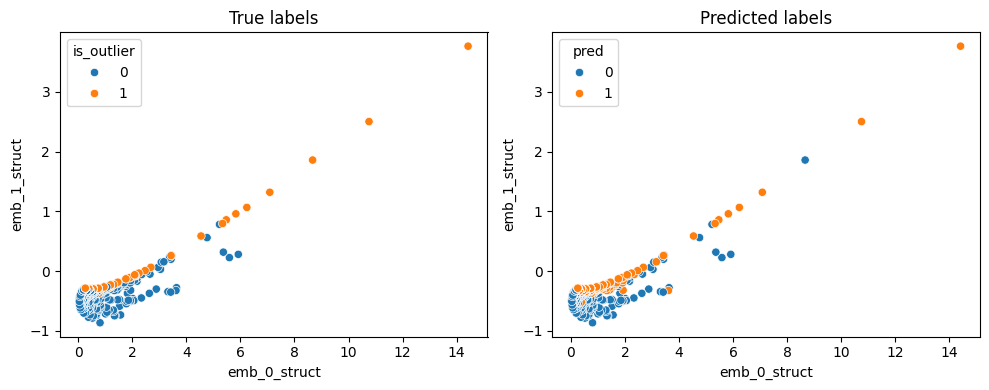

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()